In [2]:


# Common
import os 
import keras
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm 
import tensorflow as tf


# Data 
import tensorflow.image as tfi
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Data Viz
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import MaxPool2D
from keras.layers import concatenate as c_
from keras.layers import ReLU

# Model Learning Viz
from tf_explain.core.grad_cam import GradCAM

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint



In [3]:


def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def load_image(path, SIZE):
    img = load_img(path)
    img = img_to_array(img)
    img = tfi.resize(img, (SIZE, SIZE))
    img = tf.cast(img, tf.float32)
    img = img/255.
    return img



In [4]:
root_path = 'CamVid/'

train_image_paths = sorted(glob(root_path + 'train/' + "*.png"))
train_mask_paths = sorted(glob(root_path + 'train_labels/' + "*.png"))

val_image_paths = sorted(glob(root_path + 'val/' + "*.png"))
val_mask_paths = sorted(glob(root_path + 'val_labels/' + "*.png"))

test_image_paths = sorted(glob(root_path + 'test/' + "*.png"))
test_mask_paths = sorted(glob(root_path + 'test_labels/' + "*.png"))



In [5]:


SIZE = 224

train_images = np.zeros(shape=(len(train_image_paths), SIZE, SIZE, 3))
train_masks = np.zeros(shape=(len(train_image_paths), SIZE, SIZE, 3))

val_images = np.zeros(shape=(len(val_image_paths), SIZE, SIZE, 3))
val_masks = np.zeros(shape=(len(val_image_paths), SIZE, SIZE, 3))

test_images = np.zeros(shape=(len(test_image_paths), SIZE, SIZE, 3))
test_masks = np.zeros(shape=(len(test_image_paths), SIZE, SIZE, 3))

for i,path in tqdm(enumerate(train_image_paths), desc="Train Images"):
    image = load_image(path, SIZE=SIZE)
    train_images[i] = image

for i,path in tqdm(enumerate(train_mask_paths), desc="Train Masks"):
    image = load_image(path, SIZE=SIZE)
    train_masks[i] = image
    
for i,path in tqdm(enumerate(val_image_paths), desc="Valid Masks"):
    image = load_image(path, SIZE=SIZE)
    val_images[i] = image
    
for i,path in tqdm(enumerate(val_mask_paths), desc="Valid Masks"):
    image = load_image(path, SIZE=SIZE)
    val_masks[i] = image

for i,path in tqdm(enumerate(test_image_paths), desc="Test Masks"):
    image = load_image(path, SIZE=SIZE)
    test_images[i] = image
    
for i,path in tqdm(enumerate(test_mask_paths), desc="Test Masks"):
    image = load_image(path, SIZE=SIZE)
    test_masks[i] = image



Train Images: 0it [00:00, ?it/s]2023-02-25 02:58:29.436047: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-25 02:58:29.436088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (picox): /proc/driver/nvidia/version does not exist
2023-02-25 02:58:29.493821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Train Images: 369it [00:13, 27.18it/s]
Train Masks: 369it [00:04, 81.20it/s]
Valid Masks: 100it [00:03, 27.42it/s]
Valid Masks: 100it [00:01, 75.77it/s]
Test Masks: 232it [00:08, 27.29it/s]
Test Masks: 232it [00:03, 69.19it/s]


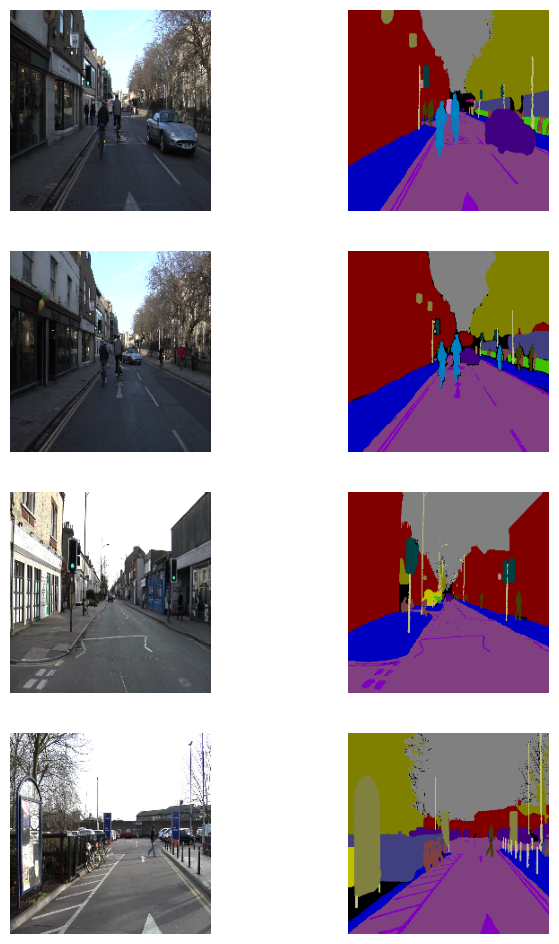

In [6]:
plt.figure(figsize=(8,12))
for i in range(8):
    plt.subplot(4,2,i+1)
    if (i+1)%2!=0:
        rand_id = np.random.randint(len(train_image_paths))
        rand_image = train_images[rand_id]
        rand_mask = train_masks[rand_id]
        show_image(rand_image)
    elif (i+1)%2==0:
        show_image(rand_mask)



In [7]:
# Contraction Block 
class EncoderBlock(Layer):
    
    def __init__(self, filters, rate, pooling=True,**kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.pool = MaxPool2D()
        self.bn = BatchNormalization()
    
    def call(self, X):
        x = self.c1(X)
        x = self.drop(x)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x
    
    def get_config(self):
        base_config = super().get_config()
        return base_config.update({
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        })


In [8]:
class DecoderBlock(Layer):
    
    def __init__(self, filters, rate,**kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)
        self.bn = BatchNormalization()
    
    def call(self, X):
        org_x, att_x = X
        x = self.up(org_x)
        x = c_([x, att_x])
        x = self.net(x)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return base_config.update({
            "filters":self.filters,
            "rate":self.rate
        })

In [9]:
class AttentionGate(Layer):
    
    def __init__(self, filters, rate, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)
        
        self.filters = filters
        self.rate = rate
        
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same')
        self.normal = Conv2D(filters, kernel_size=3, strides=1, padding='same')
        self.add = Add()
        self.act = ReLU()
        self.learn = Conv2D(1,kernel_size=1,padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.apply = Multiply()
        
        self.drop = Dropout(rate)
        
    def call(self, X):
        net_X, skip_X = X
        
        g = self.normal(net_X)
        h = self.drop(self.down(skip_X)) # this will force it to learn
        
        added = self.add([g,h])
        x = self.act(added)
        x = self.learn(x)
        x = self.resample(x)
        f = self.apply([x, skip_X])
        return f
    
    def get_config(self):
        base_estimator = super().get_config()
        return base_estimator.update({
            "filters":self.filters,
            "rate":self.rate
        })

In [10]:
# Input 
input_layer = Input(shape=(SIZE, SIZE, 3), name="Input_layer")

# Encoder 
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encodings
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder
a1 = AttentionGate(256,0, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128,0, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64,0, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32,0, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Outputs
output_layer = Conv2D(3, kernel_size=1, strides=1, padding='same', activation='sigmoid', name="Output_layer")(d4)

# Model
att_unet = Model( inputs=[input_layer], outputs=[output_layer],)


In [11]:
class ShowProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        i = np.random.randint(len(val_images))

        image, mask = val_images[i], val_masks[i]
        pred_mask = self.model.predict(image[np.newaxis,...])[0]
        exp = GradCAM()
        cam = exp.explain(
            validation_data=(image[np.newaxis,...], mask[np.newaxis,...]),
            model=self.model,
            class_index=None,
            layer_name='Attention4'
        )        
        plt.figure(figsize=(15,8))
        plt.subplot(1,4,1)
        show_image(image, title="Original Image")
        
        plt.subplot(1,4,2)
        show_image(mask, title="Original Mask")
        
        plt.subplot(1,4,3)
        show_image(pred_mask, title="Predicted Mask")
        
        plt.subplot(1,4,4)
        show_image(cam, title="CradGAM")
        
        plt.tight_layout()
        plt.show()


In [12]:
class_path = 'CamVid/class_dict.csv'
class_dict = pd.read_csv(class_path)
n_classes = len(class_dict['name'])

In [13]:
# Compiling
att_unet.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', keras.metrics.MeanIoU(num_classes=n_classes, name="IoU")]
)

Epoch 1/5
1/1 [==============================] - 1s 529ms/steposs: 0.7651 - accuracy: 0.6862 - IoU: 0.49


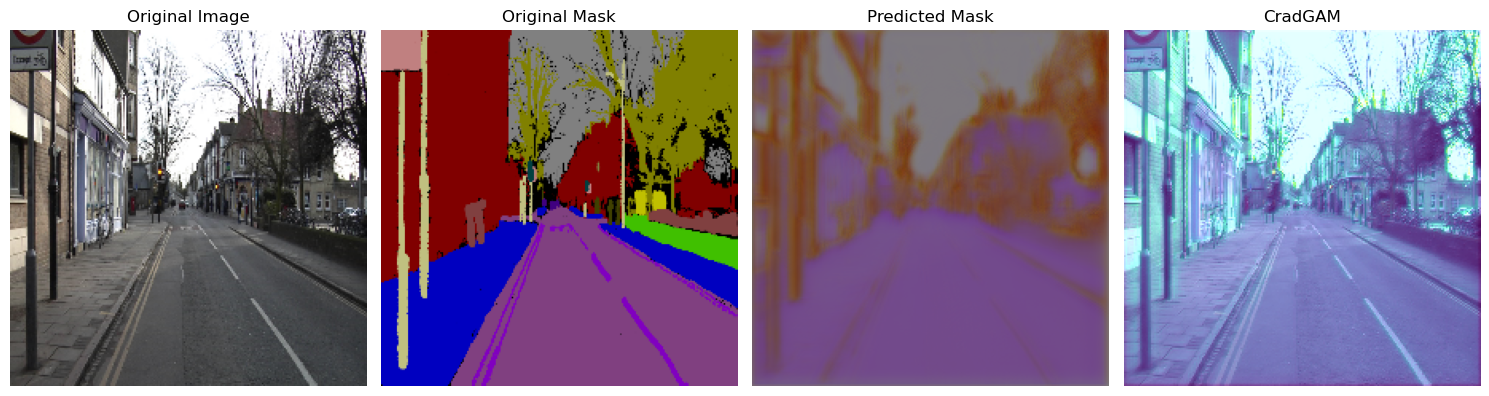

93/93 [==============================] - 393s 4s/step - loss: 0.7651 - accuracy: 0.6862 - IoU: 0.4996 - val_loss: 0.6199 - val_accuracy: 0.4110 - val_IoU: 1.0000
Epoch 2/5
19/93 [=====>........................] - ETA: 4:55 - loss: 0.6015 - accuracy: 0.6323 - IoU: 1.0000

In [ ]:
# training
nepochs=25
nbatch_size=8

results = att_unet.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=nepochs,
    callbacks=[ EarlyStopping(patience=3, monitor='IoU', mode='max', restore_best_weights=True), ShowProgress()],
    batch_size=nbatch_size
)

In [ ]:
plt.figure(figsize=(10,24))
n = 0
for i in range(1,(10*3)+1):
    plt.subplot(10,3,i)
    if n == 0:
        id = np.random.randint(len(test_images))
        image = test_images[id][np.newaxis,...]
        mask = test_masks[id]
        pred_mask = att_unet.predict(image)[0]
        image = image[0]
        show_image(image)
        n+=1
    elif n==1:
        show_image(pred_mask)
        n+=1
    elif n==2:
        show_image(mask)
        n=0
plt.tight_layout()
plt.show()
